### Algorithm overview

- Compute distance between each pair of in-nodes and out-nodes (geodesic distance on globe, later "distance" can be modified to include trade barriers, etc.)
- Probability of edge between (u,v) is proportional to in(u) * in(v) / dist(u,v)
- Connect nodes and assign weights according to iterative proportional fitting
- TODO: Validation:
    - For each country i:
        pred_exp = sum(outflows from grid cells in i that are international edges)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Gravity Model...
Gravity Model Complete. Ensemble Generated.
Running IPF...
IPF complete. Flow matrix generated.
🌍 Grid Dataset Summary
  NetCDF Source: L.T.iron_flows.2000-2016.a.nc
  Time Selected: 2000
  Inflow Var: prod_inflow (tonnes Fe per grid)
  Outflow Var: prod_outflow (tonnes Fe per grid)
  Total Flow (IO): 670,220,737.12 670,220,737.12

📊 Ensemble Graph
  Shape: (474, 14007)
  Total Weight: 143,036,510,409,253.22
  Nonzero Edges: 6638831

📦 Flow Graph
  Shape: (474, 14007)
  Total Flow: 670,220,737.12
  Nonzero Edges: 6638831


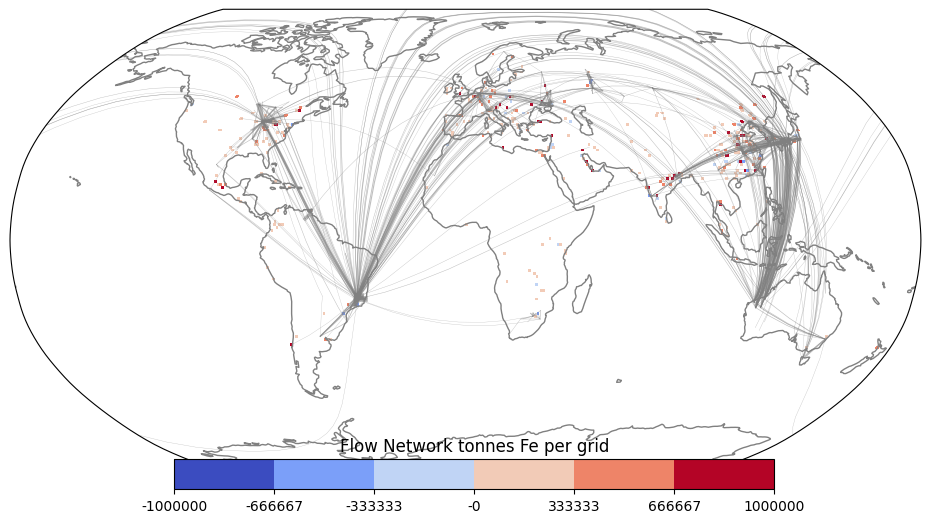

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import os
from FlowNetwork import FlowNetwork

# Initialize the flow network with NetCDF data and variable names
fn = FlowNetwork('L.T.iron_flows.2000-2016.a.nc', 'prod_outflow', 'prod_inflow', time='2000')

# Generate the ensemble using the gravity model
fn.optimized_gravity_model()

# Sample the actual flow network using IPF
fn.apply_ipf_to_ensemble()

# Integrate imports and exports over each country
# fn.compute_country_trade() # This takes forever because of how country_fraction_ds is implemented, so I run it in a script.

# Print summary of the network
print(fn)
fn.plot_network_map(edge_thickness=5, vmin=-1e6, vmax=1e6)

In [45]:
### TESTS ###
import numpy as np

# For each grid cell, the outflow from edges should be outflow from node data
def check_mass_conservation(fn, tol=1e-6):
    """
    Verify that the flow matrix conserves mass at each node, by comparing
    inflow and outflow values in the dataset to the sums of incoming and
    outgoing edges in the flow matrix.
    """

    print("Checking mass conservation...")

    inflow_pass, outflow_pass = True, True

    # Check inflow nodes: sum over columns (axis=1)
    for j, in_coord in enumerate(fn.in_coords):
        flow_in = fn.flow[:, j].sum()
        ds_in = fn.df.loc[in_coord][fn.inflow_var]
        if not np.isclose(flow_in, ds_in, atol=tol):
            inflow_pass = False
            print(f"[!] Inflow mismatch at {in_coord}: graph={flow_in:.3f}, dataset={ds_in:.3f}")

    # Check outflow nodes: sum over rows (axis=0)
    for i, out_coord in enumerate(fn.out_coords):
        flow_out = fn.flow[i, :].sum()
        ds_out = fn.df.loc[out_coord][fn.outflow_var]
        if not np.isclose(flow_out, ds_out, atol=tol):
            outflow_pass = False
            print(f"[!] Outflow mismatch at {out_coord}: graph={flow_out:.3f}, dataset={ds_out:.3f}")

    if inflow_pass and outflow_pass:
        print("✅ All nodes pass mass conservation check.")
    else:
        print("❌ Some nodes failed the check. See above for details.")

check_mass_conservation(fn)
# coord = (-33.5, 139.5)
# i = fn.coord_to_index(coord)

# print(fn.df.loc[coord])
# print(fn.flow[:, i].sum())

Checking mass conservation...
✅ All nodes pass mass conservation check.
